### In this lesson, I am going to build, train and evaluate Convolution Neural Newtwork to classify digits from 0 to 9.

In [54]:
import torch
import torchvision
from torch import nn
from torchvision.datasets import MNIST

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


config = {
    'TRAIN_BATCH_SIZE'  : 512, 
    'TEST_BATCH_SIZE'   : 256, 
    'EPOCHS'            : 10
}

In [2]:
train_loader = torch.utils.data.DataLoader(
    MNIST('', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
                             batch_size=config['TRAIN_BATCH_SIZE'], shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=config['TEST_BATCH_SIZE'], shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



# LeNet Architecture

|Layer          |Feature Map|Output Size|Kernel Size |Stride|Activation|
|---------------|-----------|--------------|------------|------|----------|
|Image          |    1      |$32 \times 32$|     -      |  -   |    -     |
|Concolution    |    6      |$28 \times 28$|$5 \times 5$|  1   | tanh     |
|Average Pooling|    6      |$14 \times 14$|$2 \times 2$|  1   |    -     |
|Convolution    |    16     |$10 \times 10$|$5 \times 5$|  1   | tanh     |
|Average Pooling|    16     |$5 \times 5$  |$2 \times 2$|  1   |    -     |
|Convolution    |    120    |$5 \times 5$  |$5 \times 5$|  1   | tanh     |
|Fully Connected|    -      |  84          |    -       |  -   | tanh     |
|Fully Connected|    -      |  10          |    -       |  -   | softmax  |

---


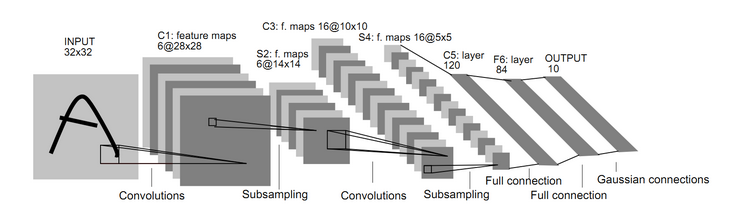

In [4]:
# Model Architecture

class LeNet(nn.Module):
    def __init__(self):
      super(LeNet, self).__init__()
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
      self.avg_pool1 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

      self.conv2= nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
      self.avg_pool2 = nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

      self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, padding=0, stride=1)
      
      self.fc1 = nn.Linear(in_features=120, out_features=84)
      self.fc2 = nn.Linear(in_features=84, out_features=10)

      self.Act = nn.Tanh()
      self.softmax = nn.Softmax(1)

    def forward(self, input_image):
      x = self.conv1(input_image)
      x = self.Act(x)
      x = self.avg_pool1(x)

      x = self.conv2(x)
      x = self.Act(x)
      x = self.avg_pool2(x)

      x = self.conv3(x)
      x = self.Act(x)

      x = x.view(-1, 120)
      x = self.fc1(x)
      x = self.Act(x)

      x = self.fc2(x)
      out = self.softmax(x)

      return out

In [6]:
STEPS_PER_EPOCH = MNIST('').train_data.shape[0] // config['TRAIN_BATCH_SIZE']
SCALE = 5

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

model = LeNet()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


print("Training ....")
for epoch in range(config['EPOCHS']):

  for idx, (data, target) in enumerate(train_loader):
    
    data = torch.Tensor(np.pad(data, [(0, 0), (0, 0), (2, 2), (2, 2)]))
    target = torch.Tensor(ohe.fit_transform(target.reshape(-1, 1)).toarray())
    optimizer.zero_grad()
    y_hat = model.forward(data)
    l = loss(y_hat, target)

    l.backward()

    optimizer.step()
    LOG = f"{f'[info]: epoch:{epoch+1}'.ljust(20)}|{'-'.ljust(idx // SCALE, '-')}>{' '.ljust((STEPS_PER_EPOCH-idx) // SCALE)}|\t loss: {l}"
    print("\r", end=LOG)
  print('')

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Training ....
[info]: epoch:1     |-----------------------> |	loss: 1.5508650541305542
[info]: epoch:2     |-----------------------> |	loss: 1.5043964385986328
[info]: epoch:3     |-----------------------> |	loss: 1.5449658632278442
[info]: epoch:4     |-----------------------> |	loss: 1.4889870882034302
[info]: epoch:5     |-----------------------> |	loss: 1.4864672422409058
[info]: epoch:6     |-----------------------> |	loss: 1.4917229413986206
[info]: epoch:7     |-----------------------> |	loss: 1.4730501174926758
[info]: epoch:8     |-----------------------> |	loss: 1.4806489944458008
[info]: epoch:9     |-----------------------> |	loss: 1.4690710306167603
[info]: epoch:10    |-----------------------> |	loss: 1.4711130857467651


In [38]:
y = MNIST('').train_labels
X = MNIST('').data
X = X.view(-1, 1, 28, 28)

y_pred = model.forward(torch.Tensor(np.pad(X, [(0, 0), (0, 0), (2, 2), (2, 2)])))
y_pred = np.argmax(y_pred.detach().numpy(), axis=1)

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5918
           1       0.99      0.95      0.97      7050
           2       0.97      0.98      0.98      5886
           3       0.98      0.92      0.95      6578
           4       0.99      0.91      0.95      6339
           5       0.88      0.99      0.93      4822
           6       0.99      0.97      0.98      6014
           7       0.98      0.92      0.95      6622
           8       0.97      0.91      0.94      6207
           9       0.76      0.99      0.86      4564

    accuracy                           0.95     60000
   macro avg       0.95      0.95      0.95     60000
weighted avg       0.96      0.95      0.95     60000

Accuracy Score: 95.08 %


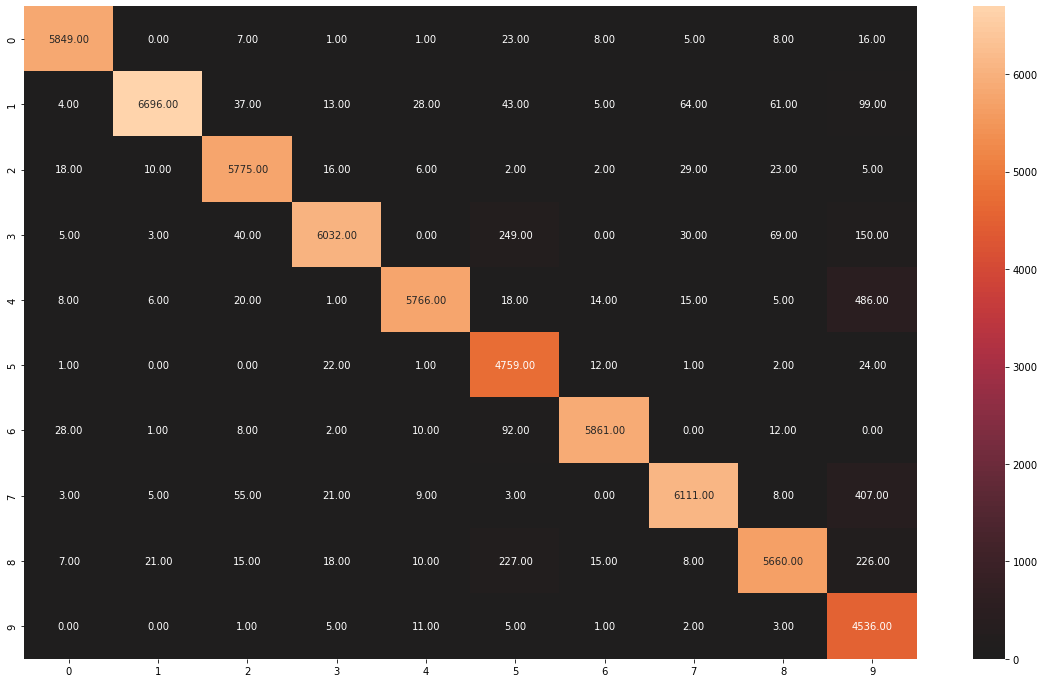

In [53]:
print(classification_report(y_pred, y))
print(f'Accuracy Score: {accuracy_score(y_pred, y) * 100:.2f} %')
cm = confusion_matrix(y_pred, y)
plt.figure(figsize=(20, 12))
sns.heatmap(cm, center=True, annot=True, fmt='.2f');

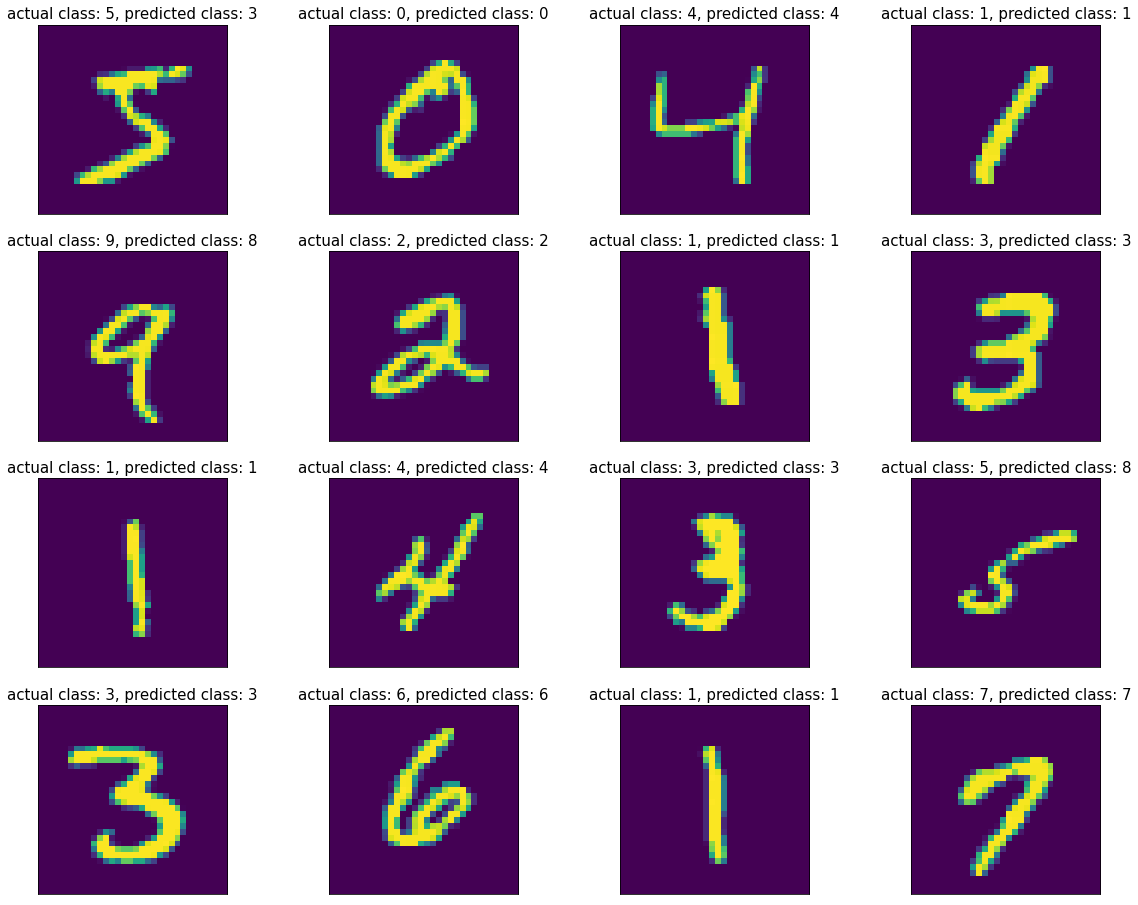

In [68]:
# Test with images
import cv2 as cv
rows, cols = 4, 4
X_test = MNIST('').test_data
y_test = MNIST('').test_labels

random_indices = np.random.randint(0, len(X_test), rows * cols)

plt.figure(figsize=(20, 16))
print('\n\n')
for i in range(rows * cols):
  x = X[i]
  x = x.view(1, 1, 28, 28)
  x = torch.Tensor(np.pad(x, [(0, 0), (0, 0), (2, 2), (2, 2)]))
  y_pred = model.forward(x)
  y_pred = np.argmax(y_pred.detach().numpy(), axis=1)
  plt.subplot(rows, cols, i+1)
  plt.imshow(x.reshape(32, 32))
  plt.xticks([]);plt.yticks([])
  plt.title(f'actual class: {y_test[i]}, predicted class: {y_pred[0]}', size=15)